# Реализация главы 2 
## Machine_Learning_for_Asset_Managers
## С использованием реальных данных sp500

In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pylab as plt
from scipy.optimize import minimize
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf

def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N 
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2 
    eVal=np.linspace(eMin,eMax,pts) 
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5 
    pdf=pd.Series(pdf,index=eVal)
    return pdf

from sklearn.neighbors import KernelDensity

def getPCA(matrix):
    
    # Get eVal,eVec from a Hermitian matrix 
    eVal,eVec=np.linalg.eigh(matrix) 
    indices=eVal.argsort()[::-1] 
    
    # arguments for sorting eVal desc 
    eVal,eVec=eVal[indices],eVec[:,indices] 
    eVal=np.diagflat(eVal)
    return eVal,eVec 

def fitKDE(obs,bWidth=.25,kernel="gaussian", x=None):
    #print('x ',x)
    #print('obs ', obs)
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated 
    if len(obs.shape)==1:obs=obs.reshape(-1,1) 
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs) 
    if x is None:x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:x=x.reshape(-1,1) 
    logProb=kde.score_samples(x) # log(density) 
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    
    return pdf

In [3]:
x=np.random.normal(size=(10000,1000))


[1.71750639 1.71382248 1.70949957 1.70681984 1.70386492]


<AxesSubplot:>

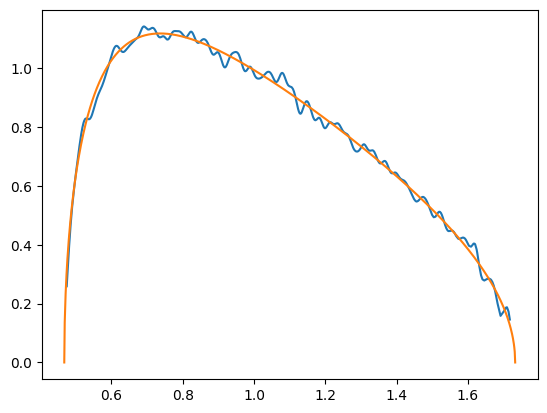

In [4]:
eVal0,eVec0=getPCA(np.corrcoef(x,rowvar=0)) 
pdf0=mpPDF(1.,q=x.shape[0]/float(x.shape[1]),pts=1000) 
pdf1=fitKDE(np.diag(eVal0),bWidth=.01) # empirical pdf
print(np.diag(eVal0)[0:5])
pdf1.plot()
pdf0.plot()

### Посмотрим на сгенерированные данные - N(mean=0, sigma=1) 

In [5]:
x=np.random.normal(.0 , 1.0, size=(10000,1000))

1000


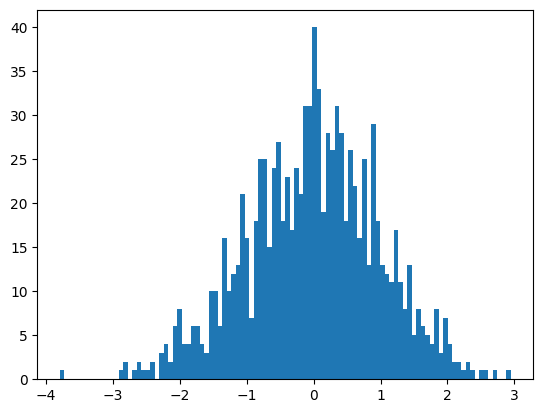

In [6]:
print(len(x[0]))
count, bins, ignored = plt.hist( x[1], 100)
plt.show()

In [7]:
matrix = np.corrcoef(x,rowvar=0)

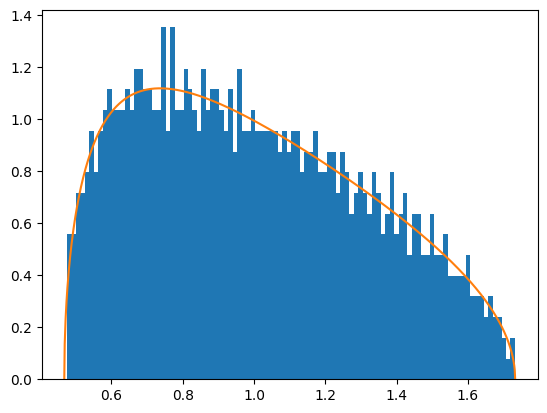

In [8]:
eVal,eVec=np.linalg.eigh(matrix)
plt.hist(eVal, 100, density=True)
pdf0.plot()
plt.show()

# Создание матрицы с шумом и сигналом

In [9]:
from scipy.optimize import minimize


def errPDFs(var,eVal,q,bWidth,pts=485):
    var = var[0]
    pdf0=mpPDF(var,q,pts) # theoretical pdf
    pdf1=fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf
    sse=np.sum((pdf1-pdf0)**2)
    return sse
  
def findMaxEval(eVal,q,bWidth):
    out=minimize(lambda *x:errPDFs(*x),.5,args=(eVal,q,bWidth),
    bounds=((1E-5,1-1E-5),))
    if out["success"]:var=out["x"][0] 
    else:var=1 
    eMax=var*(1+(1./q)**.5)**2
    return eMax,var

def getRndCov(nCols,nFacts): 
    w=np.random.normal(size=(nCols,nFacts))
    cov=np.dot(w,w.T) 
    cov+=np.diag(np.random.uniform(size=nCols)) 
    return cov

def cov2corr(cov):

    std=np.sqrt(np.diag(cov)) 
    corr=cov/np.outer(std,std) 
    corr[corr<-1],corr[corr>1]=-1,1 
    return corr



In [10]:
alpha,nCols,nFact,q=.995,1000,100,10 
cov=np.cov(np.random.normal(size=(nCols*q,nCols)),rowvar=0) 

cov=alpha*cov+(1-alpha)*getRndCov(nCols,nFact) # noise+signal 
corr0=cov2corr(cov)
eVal0,eVec0=getPCA(corr0)

eVal0[0:3]

array([[6.27344987, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 6.16307283, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 6.14920227, ..., 0.        , 0.        ,
        0.        ]])

In [11]:
eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth=.01) 
nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)

### Наблюдаем как Марченко фитит (отсекает) шум

[6.27344987 6.16307283 6.14920227 6.00486735 5.90219389]


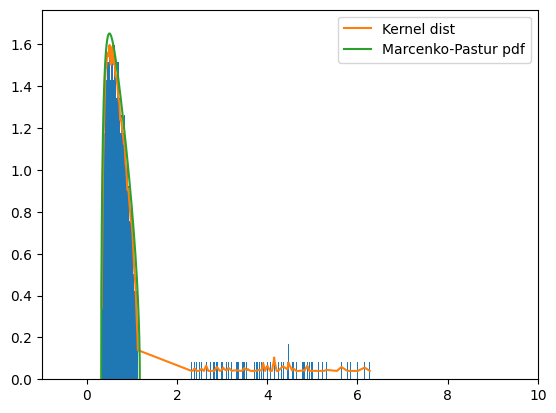

In [12]:
pdf02=mpPDF(var0,q=10,pts=1000) 
pdf1=fitKDE(np.diag(eVal0),bWidth=.01) # empirical pdf
print(np.diag(eVal0)[0:5])
plt.xlim(-1.0,10.0)

a = plt.hist(np.diag(eVal0), 500, density=True)
pdf1.plot(label="Kernel dist")
pdf02.plot(label="Marcenko-Pastur pdf")
plt.legend(loc="upper right")

# S&P500 данные


### Спарсили данные S&P500

In [13]:
import requests
from bs4 import BeautifulSoup as bs
import re
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pylab as plt
from scipy.optimize import minimize
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf

URL_TEMPLATE = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
r = requests.get(URL_TEMPLATE)
print(r.status_code)
soup = bs(r.text, "html.parser")
#soup

allSTR = soup.findAll('a', class_='external text')
ticker_list = []

for data in allSTR:
    a=re.split(':|/',data.get('href'))
    if a[-2]=='XNYS' or a[-2]=='symbol':
        ticker_list.append(a[-1])
    
ticker_list = []
i=0
for data in allSTR:
    a=re.split(':|/',data.get('href'))
    i+=1
    if a[-2]=='XNYS' or a[-2]=='symbol':
        ticker_list.append(a[-1])
    
    
    
import yfinance as yahooFinance
import datetime
 
res_matrix  = []
for ticker in ticker_list:

    GetTicherInfo = yahooFinance.Ticker(ticker)
    # startDate , as per our convenience we can modify
    startDate = datetime.datetime(2016, 1, 1)
    # endDate , as per our convenience we can modify
    endDate = datetime.datetime(2021, 1, 1)
    a=GetTicherInfo.history(start=startDate, end=endDate).Close.pct_change() 
    if len(a.values[1:]) == 1259:
        res_matrix.append(a.values[1:])
       


b = np.array(res_matrix)

200
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- CEG: Data doesn't exist for startDate = 1451595600, endDate = 1609448400
- OGN: Data doesn't exist for startDate = 1451595600, endDate = 1609448400


### Посмотрели на тикер SP500: N(mean=0, sigma = 0.024) 

1259
mean:  0.0011
sigma:  0.024


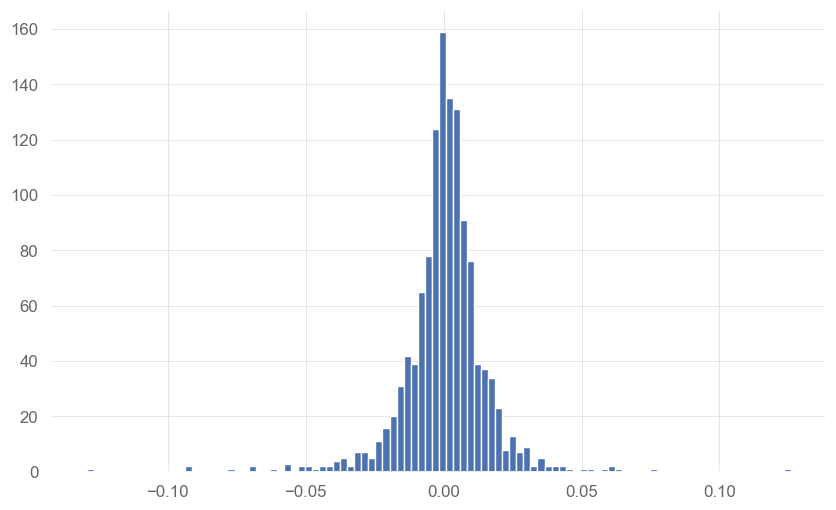

In [42]:
ticker_to_look = b[100]
print(len(ticker_to_look))
print('mean: ' ,np.mean(ticker_to_look).round(4))
print('sigma: ' ,np.std(ticker_to_look).round(4))

plt.hist( b[0], 100)
plt.show()

In [43]:
matrix_sp500 = np.corrcoef(b,rowvar=1)
matrix_sp500.shape

(484, 484)

In [44]:
#eVal_sp500,eVec_sp500=np.linalg.eigh(matrix_sp500) 
#eVal_sp500.sort()
#eMax0_sp500,var0_sp500=findMaxEval(eVal_sp500,q,bWidth=.01) 
#nFacts0_sp500=eVal_sp500.shape[0]-eVal_sp500[::-1].searchsorted(eMax0_sp500)

In [45]:
eVal_sp500,eVec_sp500 = getPCA(matrix_sp500)   # sorted
eMax0_sp500,var0_sp500=findMaxEval(np.diag(eVal_sp500),q,bWidth=.01) 
nFacts0_sp500=np.diag(eVal_sp500).shape[0]-np.diag(eVal_sp500)[::-1].searchsorted(eMax0_sp500)

In [46]:
eMax0_sp500

0.8742800563476658

In [47]:
var0_sp500

0.3000054860892639

In [48]:
nFacts0_sp500

67

### Используем Марченко_Парсел с найденным var=0.298

In [49]:
# Marcenko-Pastur pdf
# q=T/N 
var = 0.298
q=2
pts = 1000
eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2 
eVal=np.linspace(eMin,eMax,pts) 
pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5 

pdf_sp500=pd.Series(pdf,index=eVal)

## Наблюдаем хороший фиттинг

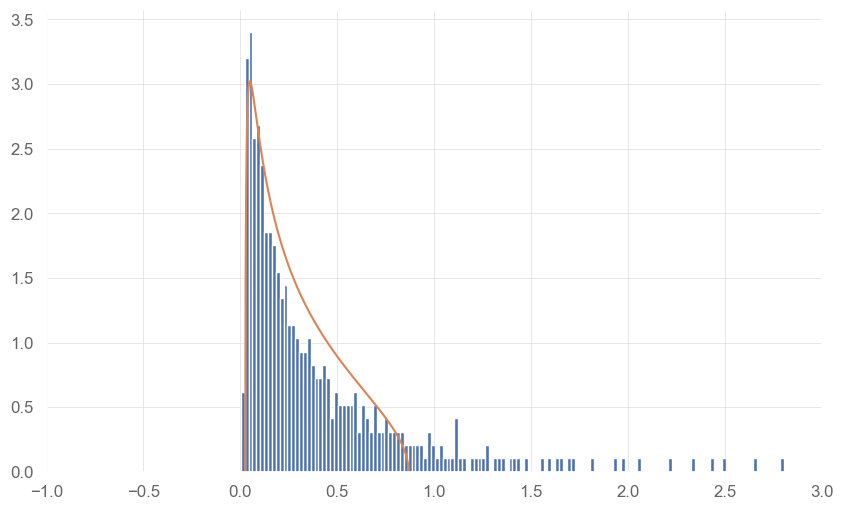

In [50]:
plt.hist(np.diag(eVal_sp500), 10000, density=True)
plt.xlim(-1.0,3.0)
pdf_sp500.plot()
plt.show()

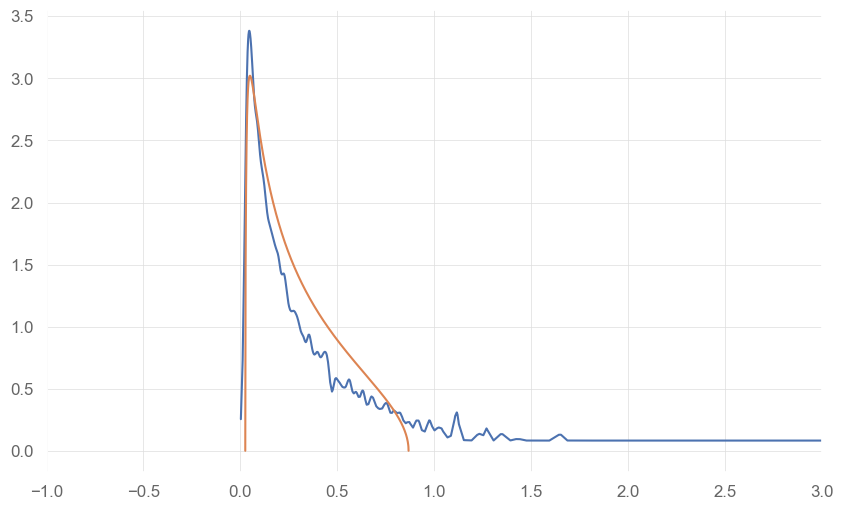

In [51]:
pdf1=fitKDE(np.diag(eVal_sp500),bWidth=.01) # empirical sp500
pdf1.plot()
plt.xlim(-1.0,3.0)
pdf_sp500.plot()
plt.show()

## Denoising 2.5

In [52]:
# code snippet 2.5 - denoising by constant residual eigenvalue
def denoisedCorr(eVal, eVec, nFacts):
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum()/float(eVal_.shape[0] - nFacts) #all but 0..i values equals (1/N-i)sum(eVal_[i..N]))
    eVal_ = np.diag(eVal_) #square matrix with eigenvalues as diagonal: eVal_.I
    corr1 = np.dot(eVec, eVal_).dot(eVec.T) #Eigendecomposition of a symmetric matrix: S = QΛQT
    corr1 = cov2corr(corr1) # Rescaling the correlation matrix to have 1s on the main diagonal
    return corr1

In [53]:
corr1=denoisedCorr(eVal0,eVec0,nFacts0) 
eVal1,eVec1=getPCA(corr1)

In [54]:
nFacts0

100

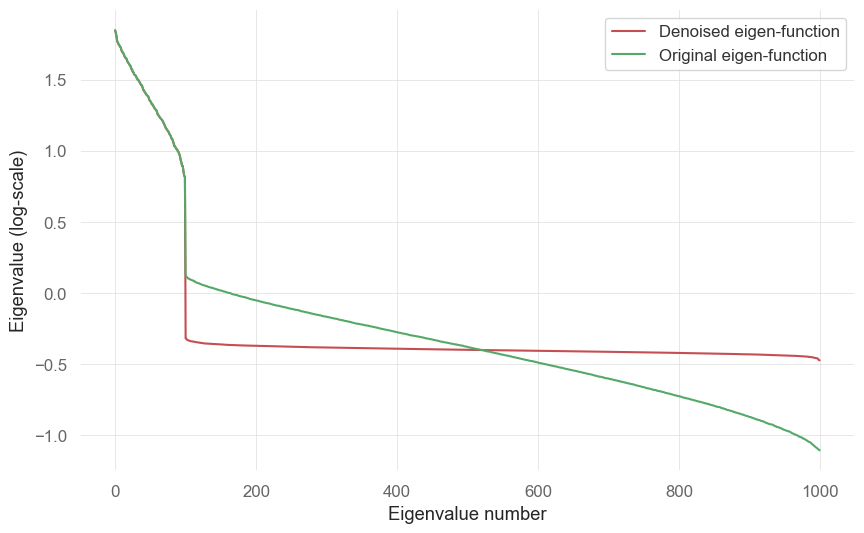

In [55]:
denoised_eigenvalue = np.diag(eVal1)
eigenvalue_prior = np.diag(eVal0)
plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), color='r', label="Denoised eigen-function")
plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), color='g', label="Original eigen-function")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")
plt.show()

### Взглянем на собственные значения до и после 

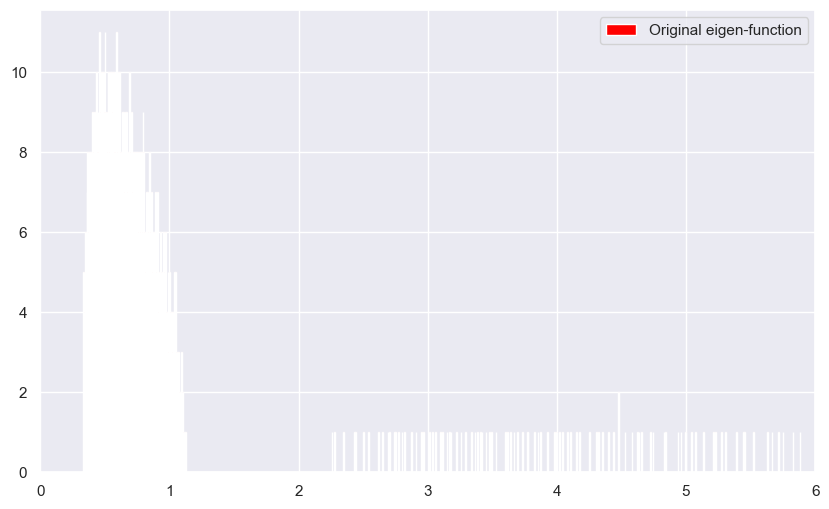

In [125]:
plt.hist(eigenvalue_prior, 1000,label="Original eigen-function", color = "red")
plt.xlim(.0,6.0)
plt.legend(loc="upper right")
plt.show()

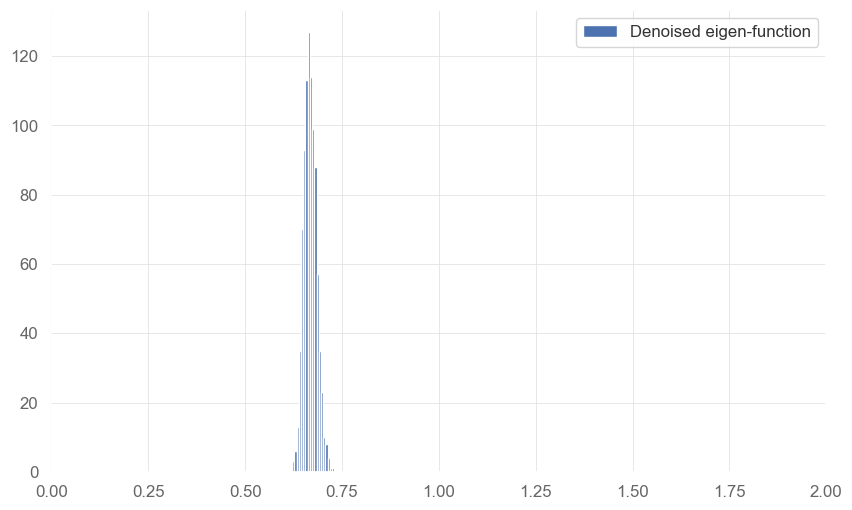

In [64]:
plt.hist(denoised_eigenvalue, 1000,label="Denoised eigen-function")
plt.xlim(.0,2.0)
plt.legend(loc="upper right")
plt.show()

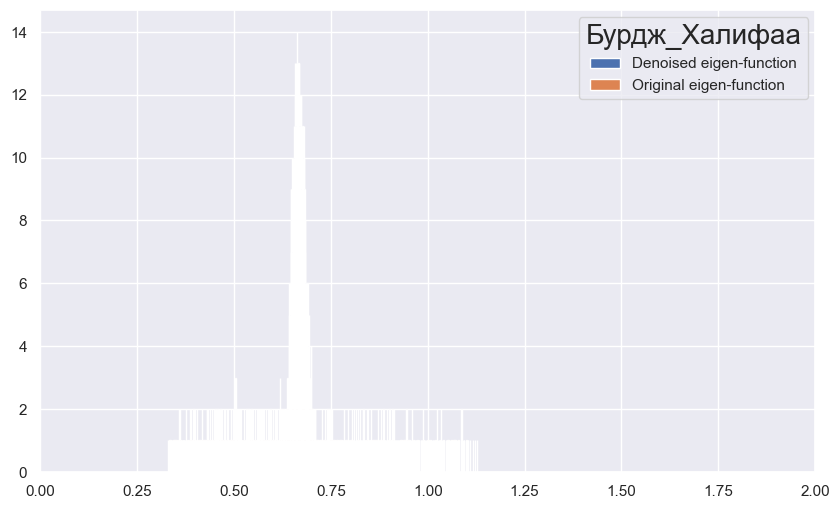

In [126]:
plt.hist(denoised_eigenvalue, 10000,label="Denoised eigen-function")
plt.hist(eigenvalue_prior, 10000,label="Original eigen-function")
plt.xlim(.0,2.0)
plt.legend(loc="upper right", title = 'Бурдж_Халифаа', title_fontsize = '20')
plt.show()

### Видим, что denoising оставил узкий диапазон собственных значений

## Denoising 2.5.2 (by targeted shrinkage) 

In [66]:
def denoisedCorr2(eVal,eVec,nFacts,alpha=0):
# Remove noise from corr through targeted shrinkage
    eValL,eVecL=eVal[:nFacts,:nFacts],eVec[:,:nFacts] 
    eValR,eVecR=eVal[nFacts:,nFacts:],eVec[:,nFacts:] 
    corr0=np.dot(eVecL,eValL).dot(eVecL.T) 
    corr1=np.dot(eVecR,eValR).dot(eVecR.T) 
    corr2=corr0+alpha*corr1+(1-alpha)*np.diag(np.diag(corr1)) 
    return corr2
corr1=denoisedCorr2(eVal0,eVec0,nFacts0,alpha=.5) 
eVal1,eVec1=getPCA(corr1)

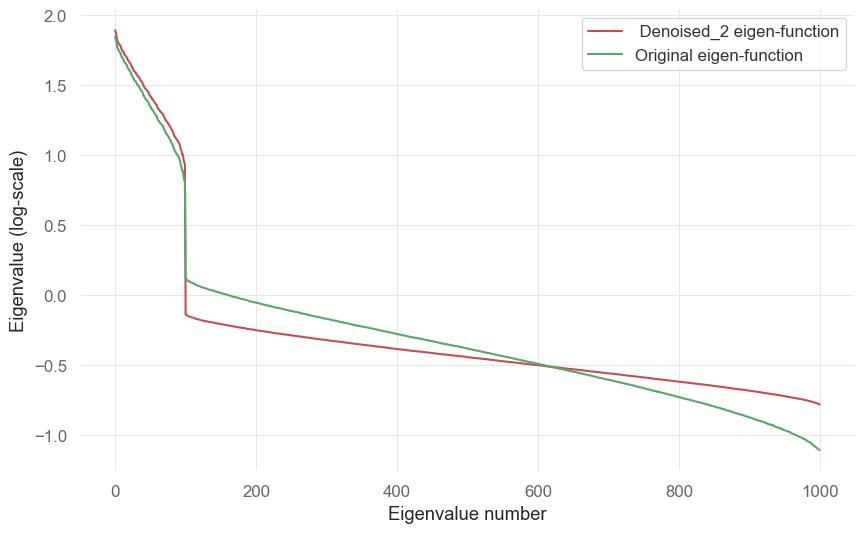

In [67]:
denoised_eigenvalue_2 = np.diag(eVal1)
plt.plot(range(0, len(denoised_eigenvalue_2)), np.log(denoised_eigenvalue_2), color='r', label=" Denoised_2 eigen-function")
plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), color='g', label="Original eigen-function")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")
plt.show()

### Посмотрим на Бурдж-халифу 2 метода

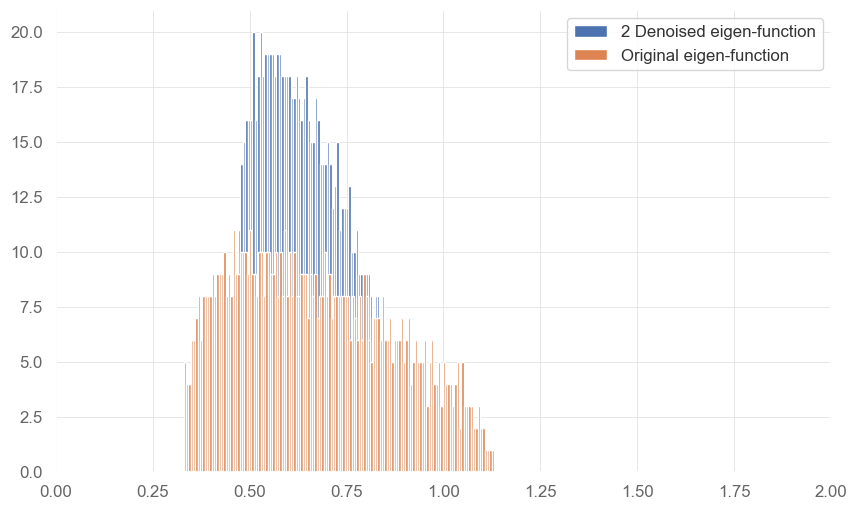

In [68]:
plt.hist(denoised_eigenvalue_2, 1000,label="2 Denoised eigen-function")
plt.hist(eigenvalue_prior, 1000,label="Original eigen-function")
plt.xlim(.0,2.0)
plt.legend(loc="upper right")
plt.show()

## Detoning 2.6 

In [69]:
def detoned_corr(corr, eigenvalues, eigenvectors, market_component=1):
 
    # Getting the eigenvalues and eigenvectors related to market component
    eigenvalues_mark = eigenvalues[:market_component, :market_component]
    eigenvectors_mark = eigenvectors[:, :market_component]
    
    # Calculating the market component correlation
    corr_mark = np.dot(eigenvectors_mark, eigenvalues_mark).dot(eigenvectors_mark.T)
    
    # Removing the market component from the de-noised correlation matrix
    corr = corr - corr_mark
    
    # Rescaling the correlation matrix to have 1s on the main diagonal
    corr = cov2corr(corr)
    
    return corr

In [70]:
def plot_denote(corr1, eVal1, eVec1, eVal0, ybound = -2):
 
    corr_detoned_denoised = detoned_corr(corr1, eVal1, eVec1)
    eVal1_detoned, eVec1_detoned = getPCA(corr_detoned_denoised)
    detoned_denoised_eigenvalue = np.diag(eVal1_detoned)
    denoised_eigenvalue = np.diag(eVal1)
    eigenvalue_prior = np.diag(eVal0)

    plt.plot(range(0, len(detoned_denoised_eigenvalue)), np.log(detoned_denoised_eigenvalue), color='b', label="Detoned, denoised eigen-function")
    plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), color='r', label="Denoised eigen-function")
    plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), color='g', label="Original eigen-function")
    plt.xlabel("Eigenvalue number")
    plt.ylabel("Eigenvalue (log-scale)")
    plt.legend(loc="upper right")
    plt.xlim(.0,eVal1.shape[0]-10)
    plt.ylim(ybound,2.5)


    plt.show()

/var/folders/t1/vqj3sfcd69x_0d_4fxms_6mr0000gn/T/ipykernel_1895/3860357933.py:9: RuntimeWarning: invalid value encountered in log
  plt.plot(range(0, len(detoned_denoised_eigenvalue)), np.log(detoned_denoised_eigenvalue), color='b', label="Detoned, denoised eigen-function")


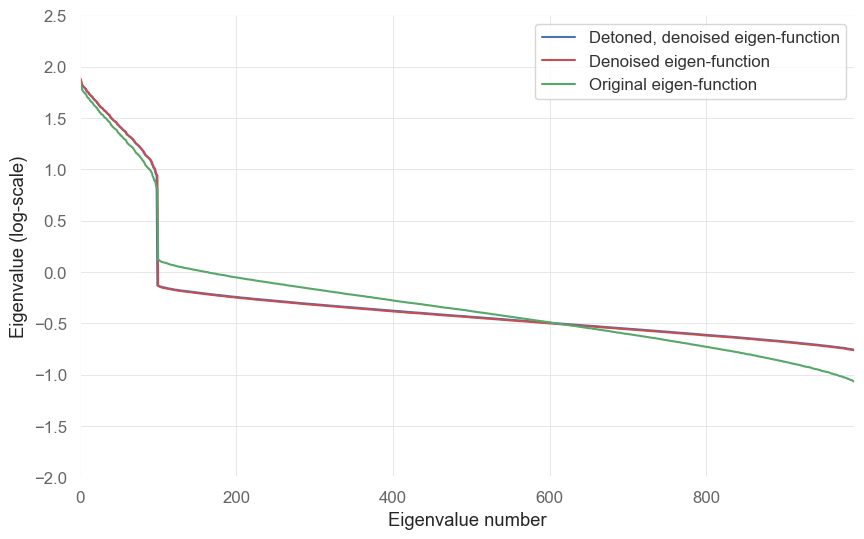

In [71]:
plot_denote(corr1, eVal1, eVec1, eVal0)


# 2.7-2.11

In [72]:
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf


def formBlockMatrix(nBlocks, bSize, bCorr):
    block = np.ones( (bSize, bSize))*bCorr
    block[range(bSize), range(bSize)] = 1 #diagonal is 1
    corr = block_diag(*([block]*nBlocks))
    return corr
    
def formTrueMatrix(nBlocks, bSize, bCorr):
    corr0 = formBlockMatrix(nBlocks, bSize, bCorr)
    corr0 = pd.DataFrame(corr0)
    cols = corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0 = corr0[cols].loc[cols].copy(deep=True)
    std0 = np.random.uniform(.05, .2, corr0.shape[0])
    cov0 = corr2cov(corr0, std0)
    mu0 = np.random.normal(std0, std0, cov0.shape[0]).reshape(-1,1)
    return mu0, cov0
    
def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov

def simCovMu(mu0, cov0, nObs, shrink=False):
    x = np.random.multivariate_normal(mu0.flatten(), cov0, size = nObs)
    #print(x.shape)
    mu1 = x.mean(axis = 0).reshape(-1,1) #calc mean of columns of rand matrix
    #print(mu1.shape)
    if shrink: cov1 = LedoitWolf().fit(x).covariance_
    else: cov1 = np.cov(x, rowvar=0)
    return mu1, cov1


def deNoiseCov(cov0, q, bWidth):
    corr0 = cov2corr(cov0)
    eVal0, eVec0 = getPCA(corr0)
    eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth)
    nFacts0 = eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1 = denoisedCorr(eVal0, eVec0, nFacts0) #denoising by constant residual eigenvalue method
    cov1 = corr2cov(corr1, np.diag(cov0)**.5)
    return cov1

def optPort(cov, mu = None):
    inv = np.linalg.inv(cov) 
    ones = np.ones(shape = (inv.shape[0], 1)) # column vector 1's
    if mu is None: 
        mu = ones
    w = np.dot(inv, mu)
    w /= np.dot(ones.T, w) # def: w = w / sum(w) ~ w is column vector
    
    return w
    

def optPortLongOnly(cov, mu = None):
    inv = np.linalg.inv(cov)
    ones = np.ones(shape = (inv.shape[0], 1)) # column vector 1's
    if mu is None: 
        mu = ones
    w = np.dot(inv, mu)
    w /= np.dot(ones.T, w) # def: w = w / sum(w) ~ w is column vector
    w = w.flatten()
    threshold = w < 0
    wpluss = w.copy()
    wpluss[threshold] = 0
    wpluss = wpluss/np.sum(wpluss)
    
    return wpluss

### Использование сгенерированной матрицы (аналог sp500)

In [73]:
nBlocks,bSize,bCorr=10,50,.5
np.random.seed(0)
mu0,cov0=formTrueMatrix(nBlocks,bSize,bCorr)

In [74]:
# code snippet 2.10
nObs, nTrials, bWidth, shrink, minVarPortf = 5, 5, .01, False, True
w1 = pd.DataFrame(columns = range(cov0.shape[0]), index = range(nTrials), dtype=float)

w1_d = w1.copy(deep=True)
np.random.seed(0)
for i in range(nTrials):
    mu1, cov1 = simCovMu(mu0, cov0, nObs, shrink = shrink)
    if minVarPortf: mu1 = None
    cov1_d = deNoiseCov(cov1, nObs*1./cov1.shape[1], bWidth)
    w1.loc[i] = optPort(cov1, mu1).flatten() # add column vector w as row in w1
    w1_d.loc[i] = optPort(cov1_d, mu1).flatten() # np.sum(w1_d, axis=1) is vector of 1's. sum(np.sum(w1_d, axis=0)= nTrials
    # so minimum-variance-portfolio is 1./nTrials*(np.sum(w1_d, axis=0)) - but distribution not stationary

min_var_port = 1./nTrials*(np.sum(w1_d, axis=0)) 
#code snippet 2.11
w0 = optPort(cov0, None if minVarPortf else mu0) # w0 true percentage asset allocation
w0 = np.repeat(w0.T, w1.shape[0], axis=0) 
rmsd = np.mean((w1-w0).values.flatten()**2)**.5     #RMSE not denoised
rmsd_d = np.mean((w1_d-w0).values.flatten()**2)**.5 #RMSE denoised
print("RMSE not denoised:"+str( rmsd))
print("RMSE denoised:"+str( rmsd_d))

RMSE not denoised:0.23623950176133782
RMSE denoised:0.0062232864116354


# Denoising реальной матрицы SP500

In [75]:
corr1_sp500=denoisedCorr(eVal_sp500,eVec_sp500,nFacts0_sp500) 
eVal1_sp500,eVec1_sp500=getPCA(corr1_sp500)


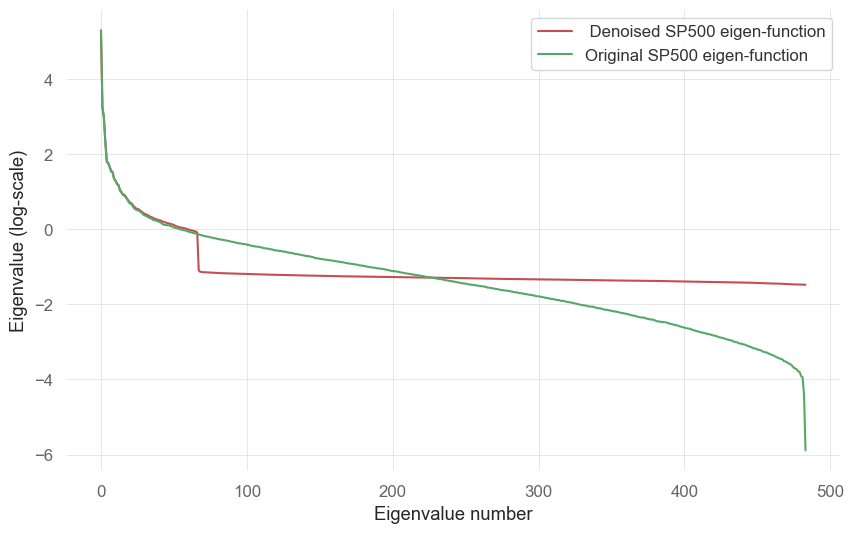

In [76]:
denoised_eigenvalue_sp500 = np.diag(eVal1_sp500)
eigenvalue_prior_sp500 = np.diag(eVal_sp500)
plt.plot(range(0, len(denoised_eigenvalue_sp500)), np.log(denoised_eigenvalue_sp500), color='r', label=" Denoised SP500 eigen-function")
plt.plot(range(0, len(eigenvalue_prior_sp500)), np.log(eigenvalue_prior_sp500), color='g', label="Original SP500 eigen-function")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc="upper right")


### Посмотрим на распределение собственных значений

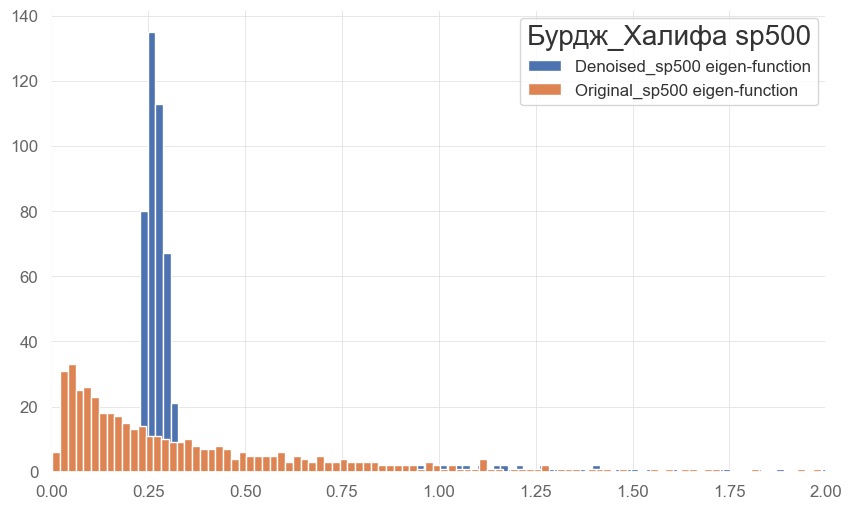

In [77]:
plt.hist(denoised_eigenvalue_sp500, 10000,label="Denoised_sp500 eigen-function")
plt.hist(eigenvalue_prior_sp500, 10000,label="Original_sp500 eigen-function")
plt.xlim(.0,2.0)
plt.legend(loc="upper right", title = 'Бурдж_Халифа sp500', title_fontsize = '20')
plt.show()

### Denoting sp_500

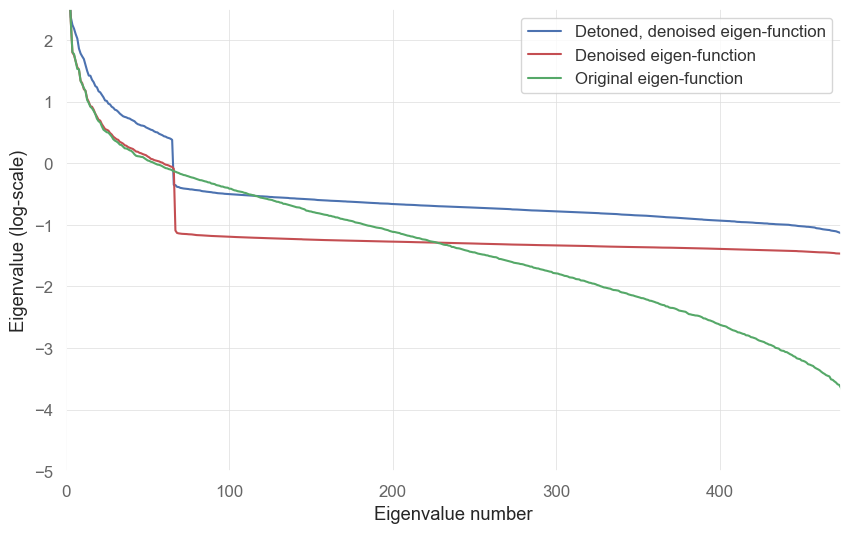

In [78]:
plot_denote(corr1_sp500, eVal1_sp500, eVec1_sp500, eVal_sp500, ybound = -5)

# Clusterisation

In [79]:
eVal_sp500,eVec_sp500 = getPCA(matrix_sp500) 

corr1_sp500=denoisedCorr(eVal_sp500,eVec_sp500,nFacts0_sp500) 
eVal1_sp500,eVec1_sp500=getPCA(corr1_sp500)

corr_detoned_denoised_sp500 = detoned_corr(corr1_sp500, eVal1_sp500, eVec1_sp500)
eVal1_detoned_sp500, eVec1_detoned_sp500 = getPCA(corr_detoned_denoised_sp500)

In [80]:
def back_spectral_copmosition(eVal, eVec):
    return eVec.dot(eVal.dot(np.linalg.inv(eVec)))

In [81]:
matrix_denoised_denoted = back_spectral_copmosition(eVal1_detoned_sp500, eVec1_detoned_sp500)

## Посмотрим на матрицу до обработки (denoising)

In [82]:
import seaborn as sns

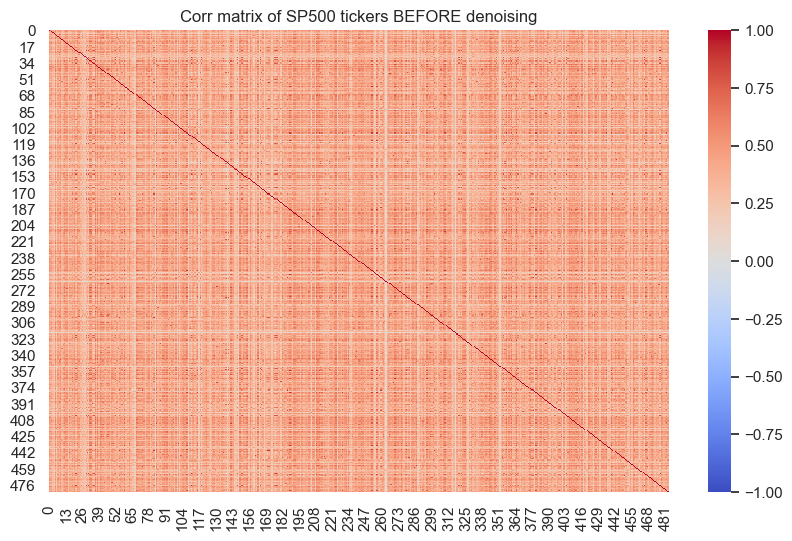

In [83]:
sns.set()
ax = sns.heatmap(matrix_sp500, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.title("Corr matrix of SP500 tickers BEFORE denoising")
plt.show()

## Посмотрим на матрицу после обработки (denoising, detoning)

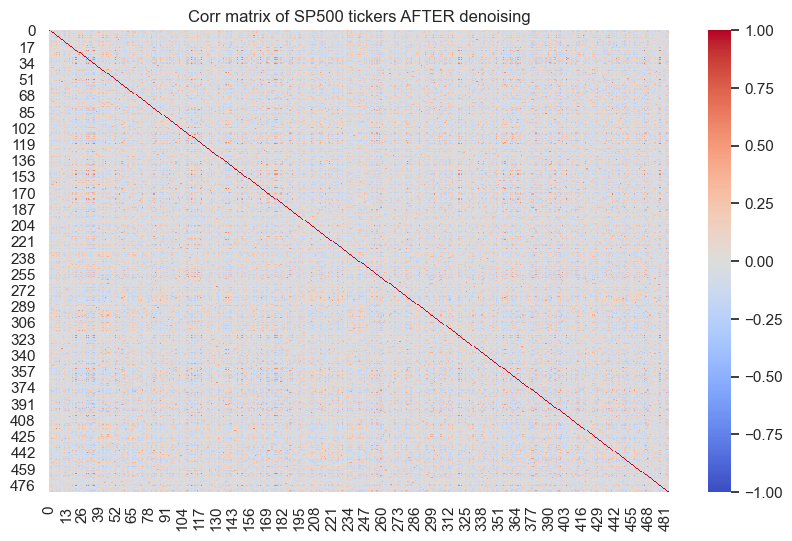

In [84]:
sns.set()
ax = sns.heatmap(matrix_denoised_denoted, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.title("Corr matrix of SP500 tickers AFTER denoising")
plt.show()

### Заметна большая разница: сильное снижение средней корреляции активов - которое было вызвано  шумом.

### В очищенных данных ищем скоррелированные активы

In [85]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.utils import check_random_state
from scipy.linalg import block_diag
import matplotlib


In [86]:
def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10, debug=False):
    corr0[corr0 > 1] = 1
    corr0 = pd.DataFrame(corr0)
    dist_matrix = ((1-corr0.fillna(0))/2.)**.5
    silh_coef_optimal = pd.Series(dtype='float64') #observations matrixs
    kmeans, stat = None, None
    maxNumClusters = min(maxNumClusters, int(np.floor(dist_matrix.shape[0]/2)))
    print("maxNumClusters"+str(maxNumClusters))
    for init in range(0, n_init):
        for num_clusters in range(2, maxNumClusters+1):
            #(maxNumClusters + 2 - num_clusters) # go in reverse order to view more sub-optimal solutions
            kmeans_ = KMeans(n_clusters=num_clusters, n_init=10) #, random_state=3425) #n_jobs=None #n_jobs=None - use all CPUs
            kmeans_ = kmeans_.fit(dist_matrix)
            silh_coef = silhouette_samples(dist_matrix, kmeans_.labels_)
            stat = (silh_coef.mean()/silh_coef.std(), silh_coef_optimal.mean()/silh_coef_optimal.std())

            # If this metric better than the previous set as the optimal number of clusters
            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh_coef_optimal = silh_coef
                kmeans = kmeans_
                if debug==True:
                    print(kmeans)
                    print(stat)
                    silhouette_avg = silhouette_score(dist_matrix, kmeans_.labels_)
                    print("For n_clusters ="+ str(num_clusters)+ "The average silhouette_score is :"+ str(silhouette_avg))
                    print("********")
    
    newIdx = np.argsort(kmeans.labels_)
    #print(newIdx)

    corr1 = corr0.iloc[newIdx] #reorder rows
    corr1 = corr1.iloc[:, newIdx] #reorder columns

    clstrs = {i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() for i in np.unique(kmeans.labels_)} #cluster members
    silh_coef_optimal = pd.Series(silh_coef_optimal, index=dist_matrix.index)
    
    return corr1, clstrs, silh_coef_optimal

In [87]:
def makeNewOutputs(corr0, clstrs, clstrs2):
    clstrsNew, newIdx = {}, []
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs[i])
    
    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs2[i])
    
    newIdx = [j for i in clstrsNew for j in clstrsNew[i]]
    corrNew = corr0.loc[newIdx, newIdx]
    
    dist = ((1 - corr0.fillna(0)) / 2.)**.5
    kmeans_labels = np.zeros(len(dist.columns))
    for i in clstrsNew.keys():
        idxs = [dist.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs] = i
    
    silhNew = pd.Series(silhouette_samples(dist, kmeans_labels), index=dist.index)
    
    return corrNew, clstrsNew, silhNew

In [88]:
def clusterKMeansTop(corr0: pd.DataFrame, maxNumClusters=None, n_init=10):
    if maxNumClusters == None:
        maxNumClusters = corr0.shape[1]-1
        
    corr1, clstrs, silh = clusterKMeansBase(corr0, maxNumClusters=min(maxNumClusters, corr0.shape[1]-1), n_init=10)#n_init)
    print("clstrs length:"+str(len(clstrs.keys())))
    print("best clustr:"+str(len(clstrs.keys())))
    #for i in clstrs.keys():
    #    print("std:"+str(np.std(silh[clstrs[i]])))

    clusterTstats = {i:np.mean(silh[clstrs[i]])/np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean = sum(clusterTstats.values())/len(clusterTstats)
    redoClusters = [i for i in clusterTstats.keys() if clusterTstats[i] < tStatMean]
    #print("redo cluster:"+str(redoClusters))
    if len(redoClusters) <= 2:
        print("If 2 or less clusters have a quality rating less than the average then stop.")
        print("redoCluster <=1:"+str(redoClusters)+" clstrs len:"+str(len(clstrs.keys())))
        return corr1, clstrs, silh
    else:
        keysRedo = [j for i in redoClusters for j in clstrs[i]]
        corrTmp = corr0.loc[keysRedo, keysRedo]
        _, clstrs2, _ = clusterKMeansTop(corrTmp, maxNumClusters=min(maxNumClusters, corrTmp.shape[1]-1), n_init=n_init)
        print("clstrs2.len, stat:"+str(len(clstrs2.keys())))
        #Make new outputs, if necessary
        dict_redo_clstrs = {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters}
        corrNew, clstrsNew, silhNew = makeNewOutputs(corr0, dict_redo_clstrs, clstrs2)
        newTstatMean = np.mean([np.mean(silhNew[clstrsNew[i]])/np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()]) 
        if newTstatMean <= tStatMean:
            print("newTstatMean <= tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))+" <= "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corr1, clstrs, silh
        else: 
            print("newTstatMean > tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))
                  +" > "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corrNew, clstrsNew, silhNew

# Применяем алгоритм кластеризации на матрице SP500, прощедшей процедуру denoising и detoning.

In [89]:
a,b,c = clusterKMeansBase(matrix_denoised_denoted, maxNumClusters=10, n_init=10)

maxNumClusters10


## Видим деление на 2 кластера

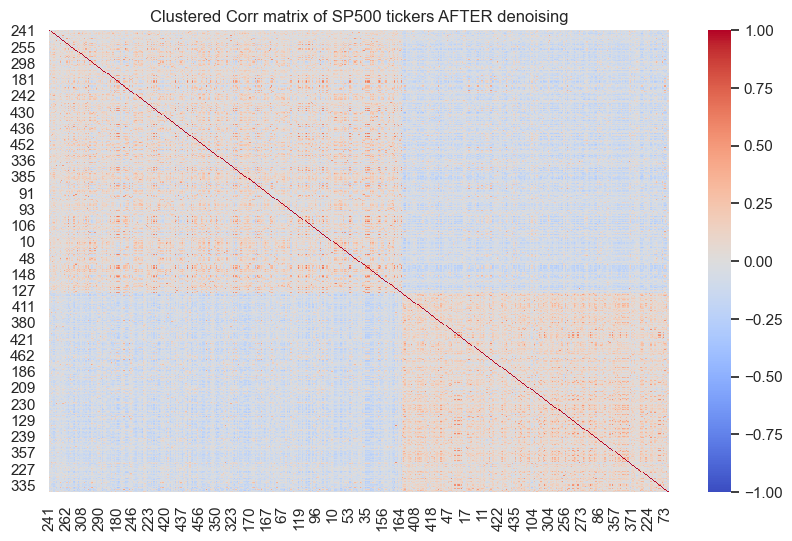

In [90]:
sns.set()
ax = sns.heatmap(a, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.title("Clustered Corr matrix of SP500 tickers AFTER denoising")
plt.show()

In [91]:
Best_metric = 0
Num_best_cluster = 0
print("Number of clusters: ", len(b.keys()))
for i in range(len(b.keys())):
    metric = np.mean(c[b[i]])/np.std(c[b[i]])
    print("Cluster ", i+1, ': metric of quality: ', metric)
    if metric > Best_metric:
        Best_metric = metric
        Num_best_cluster = i

print("Best cluster is cluster number: ", Num_best_cluster+1)

Number of clusters:  2
Cluster  1 : metric of quality:  1.8012920653473619
Cluster  2 : metric of quality:  2.6332110861725684
Best cluster is cluster number:  2


# Применяем более сложный алгоритм кластеризации на матрице SP500, прощедшей процедуру denoising и detoning.

In [92]:
corr_new, clstrs, silh_coef_optimal  = clusterKMeansTop(matrix_denoised_denoted, maxNumClusters=50, n_init=10)

maxNumClusters50
clstrs length:2
best clustr:2
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[1] clstrs len:2


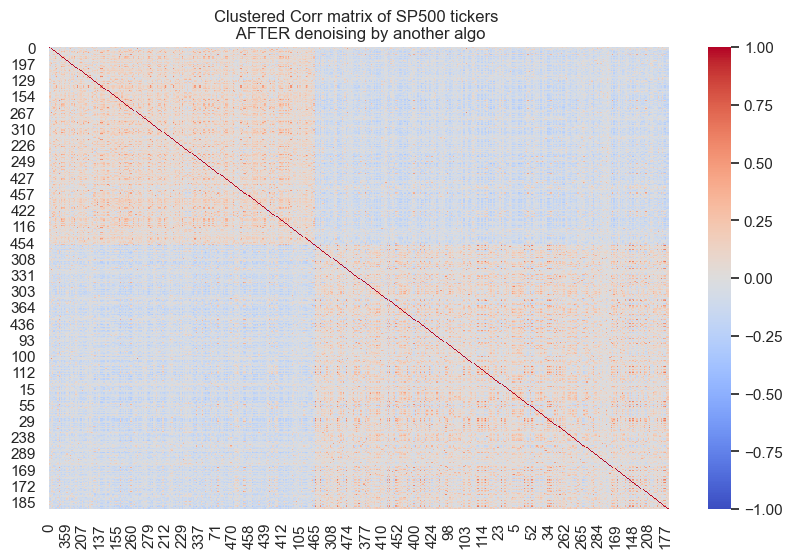

In [93]:
sns.set()
ax = sns.heatmap(corr_new, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.title("Clustered Corr matrix of SP500 tickers \n AFTER denoising by another algo")
plt.show()

In [94]:
Best_metric = 0
Num_best_cluster = 0
print("Number of clusters: ", len(clstrs.keys()))
for i in range(len(clstrs.keys())):
    metric = np.mean(silh_coef_optimal[clstrs[i]])/np.std(silh_coef_optimal[clstrs[i]])
    print("Cluster ", i+1, ': metric of quality: ', metric)
    if metric > Best_metric:
        Best_metric = metric
        Num_best_cluster = i

print("Best cluster is cluster number: ", Num_best_cluster+1)

Number of clusters:  2
Cluster  1 : metric of quality:  2.6332110861725684
Cluster  2 : metric of quality:  1.8012920653473619
Best cluster is cluster number:  1


### Тот же результат

## Продолжаем дальнейшее исследование с помощью based алгоритма

In [95]:
def recursion_clustering(n, matrix, return_need = False):
    j = 1
    a = matrix
    Num_best_cluster = 0
    Best_metric = 0
    metric = 0
    while n!=0:
        n=n-1
        a,b,c = clusterKMeansBase(a, maxNumClusters=10, n_init=10)
       
        print('Iteration number: ', j )

        sns.set()
        ax = sns.heatmap(a, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
        if j == 1:
            plt.title("Doing clustering")
        else:
            plt.title("Doing clustering on sliced datas \n next iteration")
        plt.show()
        
        print("Number of clusters: ", len(b.keys()))
        
        for i in range(len(b.keys())):
            metric = np.mean(c[b[i]])/np.std(c[b[i]])
            print("Cluster ", i+1, ': metric of quality: ', metric)
            if metric > Best_metric:
                Best_metric = metric
                Num_best_cluster = i
        
        print("Best cluster is cluster number: ", Num_best_cluster+1)
        if n!=0: print('Using him for next iteration.')
        print('\n')
        print('\n')


        a = a.loc[b[Num_best_cluster],b[Num_best_cluster]]
        j += 1
        Num_best_cluster = 0
        Best_metric = 0
        metric = 0
        
    if return_need == True:
        return a

### Испольщуем реккурсивную функцию для повторения процедуры кластеризации для полученных кластеров

maxNumClusters10
Iteration number:  1


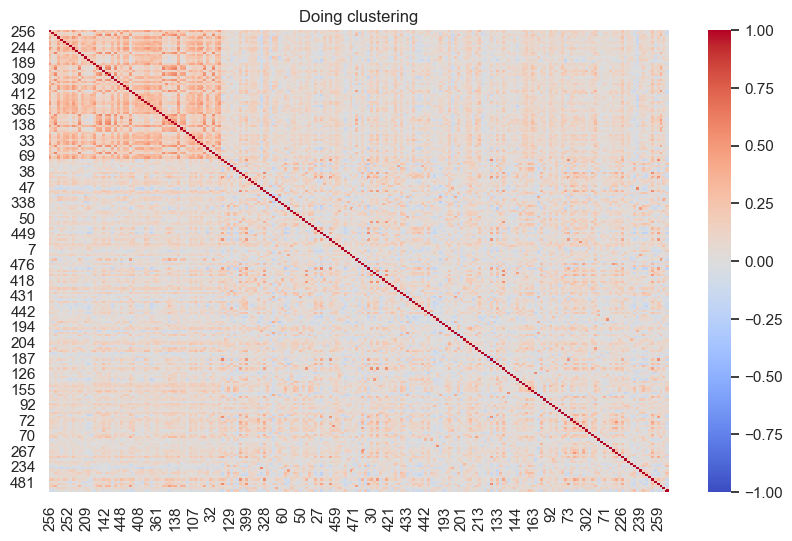

Number of clusters:  2
Cluster  1 : metric of quality:  2.358794443873851
Cluster  2 : metric of quality:  1.8877674899302597
Best cluster is cluster number:  1
Using him for next iteration.




maxNumClusters10
Iteration number:  2


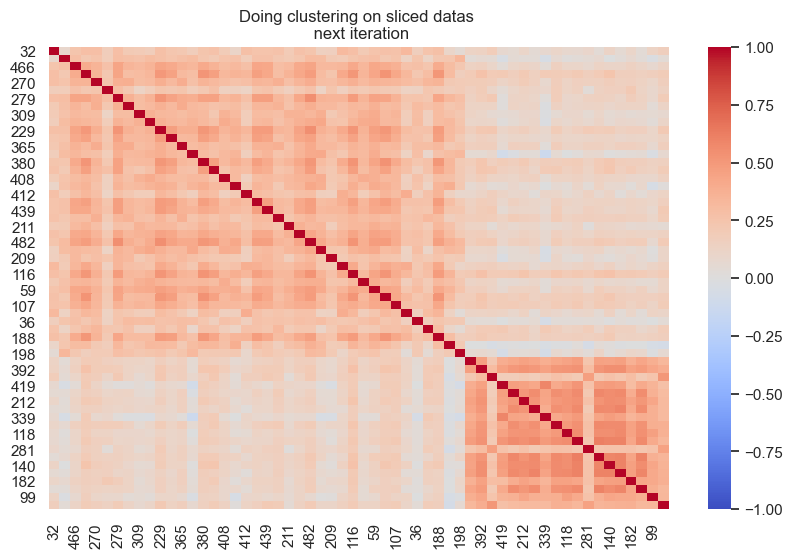

Number of clusters:  2
Cluster  1 : metric of quality:  5.496001467366184
Cluster  2 : metric of quality:  4.013035580621454
Best cluster is cluster number:  1






In [120]:
best_cluster = recursion_clustering(n=2, matrix = a.loc[b[1],b[1]], return_need = True) # скормили кластер после первой кластеризации based algo

### Попробуем скормить руккурентной функцие кластеры после Top алгоритма (just in case)

maxNumClusters10
Iteration number:  1


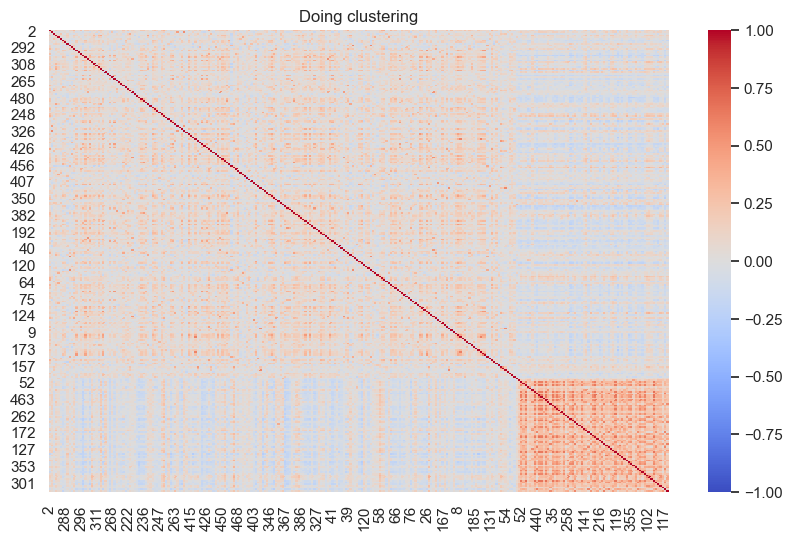

Number of clusters:  2
Cluster  1 : metric of quality:  2.382821031924842
Cluster  2 : metric of quality:  2.811059875768028
Best cluster is cluster number:  2
Using him for next iteration.




maxNumClusters10
Iteration number:  2


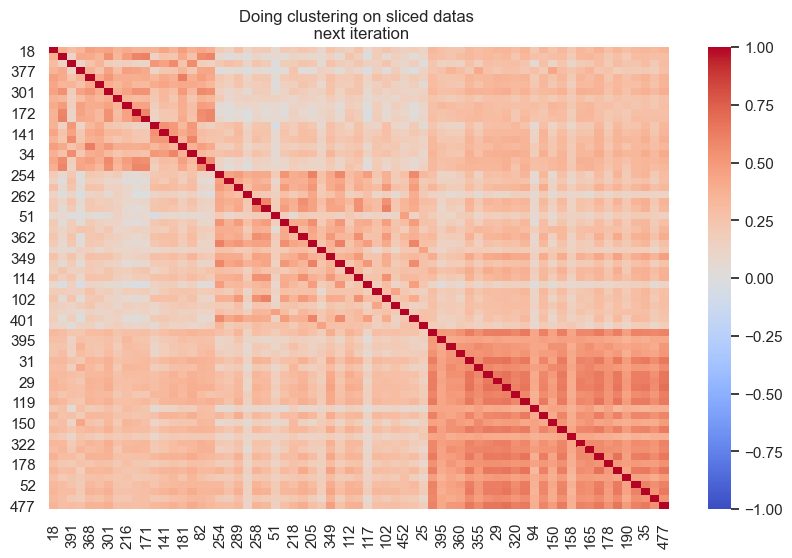

Number of clusters:  3
Cluster  1 : metric of quality:  3.3687500082714505
Cluster  2 : metric of quality:  2.5348957293927055
Cluster  3 : metric of quality:  3.2881845237928595
Best cluster is cluster number:  1






In [97]:
res_cluster = recursion_clustering(n=2, matrix = corr_new.loc[clstrs[1],clstrs[1]], return_need = True) # скормили кластер после первой кластеризации Top algo

## Посмотрим на корреляцию активов отобранного кластера

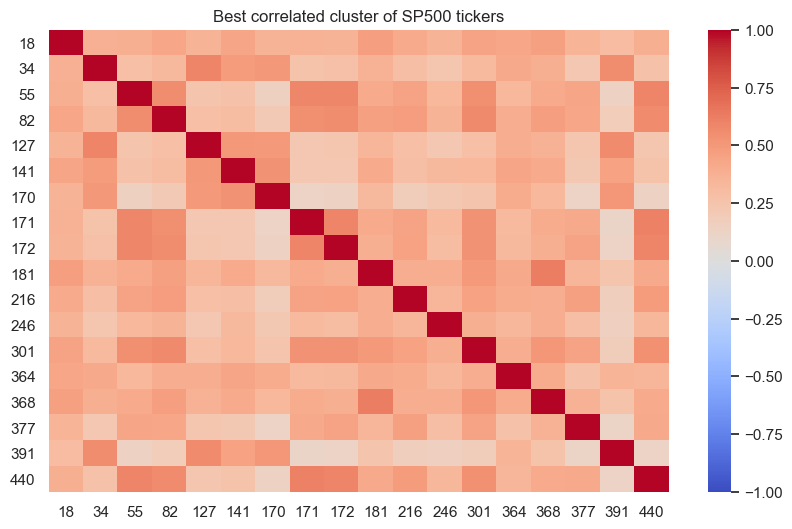

Metric of quality (mean/std):  3.4
Number of tickers in cluster:  18


In [100]:
sns.set()
ax = sns.heatmap(res_cluster, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.title("Best correlated cluster of SP500 tickers")
plt.show()

print('Metric of quality (mean/std):  3.4')
print('Number of tickers in cluster: ', res_cluster.shape[0])

In [101]:
res_cluster.columns

Int64Index([ 18,  34,  55,  82, 127, 141, 170, 171, 172, 181, 216, 246, 301,
            364, 368, 377, 391, 440],
           dtype='int64')

# Реализовали функцию главы 8 - метрика качества кластера: Sharp/var

## Функция считает средний шарп тикеров кластера и делит на среднюю вариацию

In [137]:
import quantstats as qs
from scipy.stats import norm, percentileofscore
from tqdm.notebook import tqdm
import itertools

def give_me_your_cluster(best_cluster, all_trials_matrix):

    trail_best_cluster = pd.DataFrame(all_trials_matrix).loc[best_cluster.columns]


    sharp_cluster = []
    for i in range(len(best_cluster)):
       # print(f'Sharpe ratio {i+1}:\n{qs.stats.sharpe(trail_best_cluster.iloc[i])}\n')
        sharp_cluster.append(qs.stats.sharpe(trail_best_cluster.iloc[i]))
        
    return len(np.array(sharp_cluster)), np.array(sharp_cluster).mean(),np.array(sharp_cluster).std()

def getExpectedMaxSR(nTrials, meanSR, stdSR):
    #Expected max SR, controlling for SBuMT
    emc = 0.577215664901532860606512090082402431042159336 #Euler-Mascheronis Constant
    sr0 = (1-emc)*norm.ppf(1-1./nTrials)+emc*norm.ppf(1-(nTrials*np.e)**-1)
    sr0 = meanSR + stdSR*sr0
    return sr0



## Посмотрим отношение sharp/var для отобранного кластера (18 тикеров)

In [112]:
nTrials, meanSR, stdSR = give_me_your_cluster(res_cluster, pd.DataFrame(res_matrix))
getExpectedMaxSR(nTrials, meanSR, stdSR)

1.0010141700407758

## Проверим еще один кластер (42 тикера) на качество 

In [122]:
nTrials, meanSR, stdSR = give_me_your_cluster(best_cluster, pd.DataFrame(res_matrix))
getExpectedMaxSR(nTrials, meanSR, stdSR)

0.803189531067962

## первый кластер с 18 тикерами показал большее отношение Sharp/var

# Реализация методов главы 7 и 8 на симуляционных данных

In [127]:
class Chapter7:
    def minVarPort(self,cov):
        return ch2.optPort(cov, mu = None)
    
    def optPort_nco(self,cov, mu=None, maxNumClusters=10):
        cov = pd.DataFrame(cov)
        if mu is not None:
            mu = pd.Series(mu[:,0])

        corr1 = ch2.cov2corr(cov)

        # Optimal partition of clusters (step 1)
        corr1, clstrs, _ = ch4.clusterKMeansBase(corr1, maxNumClusters, n_init=10)
        w_intra_clusters = pd.DataFrame(0, index=cov.index, columns=clstrs.keys())
        for i in clstrs:
            cov_cluster = cov.loc[clstrs[i], clstrs[i]].values
            if mu is None:
                mu_cluster = None
            else: 
                mu_cluster = mu.loc[clstrs[i]].values.reshape(-1,1)
            # Estimating the Convex Optimization Solution in a cluster (step 2)
            w_intra_clusters.loc[clstrs[i], i] = self.allocate_cvo(cov_cluster, mu_cluster).flatten()        

        cov_inter_cluster = w_intra_clusters.T.dot(np.dot(cov, w_intra_clusters)) #reduce covariance matrix
        mu_inter_cluster = (None if mu is None else w_intra_clusters.T.dot(mu))

        # Optimal allocations across the reduced covariance matrix (step 3)
        w_inter_clusters = pd.Series(self.allocate_cvo(cov_inter_cluster, mu_inter_cluster).flatten(), index=cov_inter_cluster.index)    

        # Final allocations - dot-product of the intra-cluster and inter-cluster allocations (step 4)
        nco = w_intra_clusters.mul(w_inter_clusters, axis=1).sum(axis=1).values.reshape(-1,1)
        return nco

    def allocate_cvo(self, cov, mu_vec=None):
        # Calculating the inverse covariance matrix
        inv_cov = np.linalg.inv(cov)

        # Generating a vector of size of the inverted covariance matrix
        ones = np.ones(shape=(inv_cov.shape[0], 1))

        if mu_vec is None:  # To output the minimum variance portfolio
            mu_vec = ones

        # Calculating the analytical solution using CVO - weights
        w_cvo = np.dot(inv_cov, mu_vec)
        w_cvo /= np.dot(mu_vec.T, w_cvo)

        return w_cvo    

In [128]:
class Chapter8:
    # code snippet 8.1 - experimental validation of the false strategy theorem
    # Calculates the theoretical E[SR_(n)] = expected Sharpe Ratio of the n'th order statistics (max)
    def getExpectedMaxSR(self, nTrials, meanSR, stdSR):
        # Expected max SR, controlling for SBuMT
        emc = 0.577215664901532860606512090082402431042159336  # Euler-Mascheronis Constant
        sr0 = (1 - emc) * norm.ppf(1 - 1. / nTrials) + emc * norm.ppf(1 - (nTrials * np.e) ** -1)
        sr0 = meanSR + stdSR * sr0
        return sr0


    def getDistMaxSR(self, nSims, nTrials, stdSR, meanSR):
        # Monte carlo of max{SR} on nTrials, from nSims simulations
        rng = np.random.RandomState()
        out = pd.DataFrame()
        for nTrials_ in tqdm(nTrials):
            # 1) Simulated Sharpe ratios
            sr = pd.DataFrame(rng.randn(nSims, nTrials_))  # Return a sample (or samples) from the “standard normal”
            # distribution.
            sr = sr.sub(sr.mean(axis=1), axis=0)  # center
            sr = sr.div(sr.std(axis=1), axis=0)  # scale
            sr = meanSR + sr * stdSR
            # 2) Store output
            out_ = sr.max(axis=1).to_frame('max{SR}')
            out_['nTrials'] = nTrials_
            out = out.append(out_, ignore_index=True)
        return out

    def getMeanStdError(self, nSims0, nSims1, nTrials, stdSR=1, meanSR=0):
        # compute standard deviation of errors per nTrials
        # nTrials: [number of SR used to derive max{SR}]
        # nSims0: number of max{SR} u{sed to estimate E[max{SR}]
        # nSims1: number of errors on which std is computed
        sr0 = pd.Series({i: self.getExpectedMaxSR(i, meanSR, stdSR) for i in nTrials})
        sr0 = sr0.to_frame('E[max{SR}]')
        sr0.index.name = 'nTrials'
        err = pd.DataFrame()
        for i in tqdm(range(0, int(nSims1))):
            sr1 = self.getDistMaxSR(nSims=nSims0, nTrials=nTrials, meanSR=0, stdSR=1)
            sr1 = sr1.groupby('nTrials').mean()
            err_ = sr0.join(sr1).reset_index()
            err_['err'] = err_['max{SR}'] / err_['E[max{SR}]'] - 1.
            err = err.append(err_)
        out = {'meanErr': err.groupby('nTrials')['err'].mean()}
        out['stdErr'] = err.groupby('nTrials')['err'].std()
        out = pd.DataFrame.from_dict(out, orient='columns')
        return out
    
    @staticmethod
    def plot(nTrials, sr0, sr1):
        nnSR0 = list(itertools.chain.from_iterable(itertools.repeat(x, 100) for x in sr0.values))
        deviationFromExpectation = abs(sr1['max{SR}'] - nnSR0)

        ax = sr1.plot.scatter(x='nTrials', y='max{SR}', label='Max{SR} (observed)', c=deviationFromExpectation,
                              cmap=mpl.cm.viridis.reversed())  # c: Array of values to use for marker colors.
        ax.set_xscale('log')
        ax.plot(nTrials, sr0, linestyle='--', linewidth=1, label='E[max{SR}} (prior)', color='black')
        plt.legend()
        
    @staticmethod
    # code snippet 8.3 - Type I (False positive), with numerical example (Type II False negative)
    def getZStat( sr, t, sr_=0, skew=0, kurt=3):
        z = (sr - sr_) * (t - 1) ** .5
        z /= (1 - skew * sr + (kurt - 1) / 4. * sr ** 2) ** .5
        return z

    @staticmethod
    def type1Err( z, k=1):
        # false positive rate
        alpha = ss.norm.cdf(-z)
        alpha_k = 1 - (1 - alpha) ** k  # multi-testing correction
        return alpha_k

    @staticmethod
    # code snippet 8.4 - Type II error (false negative) - with numerical example
    def getTheta(sr, t, sr_=0., skew=0., kurt=3):
        theta = sr_ * (t - 1) ** .5
        theta /= (1 - skew * sr + (kurt - 1) / .4 * sr ** 2) ** .5
        return theta

    @staticmethod
    def type2Err(alpha_k, k, theta):
        # false negative rate
        z = ss.norm.ppf((1 - alpha_k) ** (1. / k))  # Sidak's correction
        beta = ss.norm.cdf(z - theta)
        return beta
    